In [2]:
#Refer to TASK 6 at: https://www.tng-project.org/data/docs/api/
#Also refer to: https://www.tng-project.org/data/docs/specifications/#parttype4

#Set of preliminary definitions, might add to this later

from __future__ import print_function, division

import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

from io import StringIO
import io

from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
from astropy.constants import G, h, k_B


#imported requests
import requests

baseUrl = 'http://www.tng-project.org/api/'
headers = {"api-key":"bc47cc6e1bd83ad2708bc714f126dc09"}

#defined get()
def get(path, params=None):
    # make HTTP GET request to path
    headers = {"api-key":"bc47cc6e1bd83ad2708bc714f126dc09"}
    r = requests.get(path, params=params, headers=headers)

    # raise exception if response code is not HTTP SUCCESS (200)
    r.raise_for_status()

    if r.headers['content-type'] == 'application/json':
        return r.json() # parse json responses automatically

    if 'content-disposition' in r.headers:
        filename = r.headers['content-disposition'].split("filename=")[1]
        with open(filename, 'wb') as f:
            f.write(r.content)
        return filename # return the filename string

    return r


    o> plot mass-size relation for galaxies at z=2 with log M > 10
    o> pick just one galaxy at z=2 with log M > 10
    o> for this one galaxy, download the initial mass and formation time for all its o stellar particles
    o> convert formation time from units of scale factor to units of age of the Universe in Gyr
    o> make histogram of formation time
    o> make histogram of formation time weighted by the initial mass
    o> refer to Task 6

In [3]:
redshift = 2.0
h = 0.6774 #in TNG100-1 scaling
scale_factor = a = 1.0 / (1+redshift)
solar_Z = 0.0127 #unsure if this needs to be changed

#select for mass range
mass_min = 10**10 / 1e10 * h
#mass_max = 10**12 / 1e10 * h

# form the search_query string by hand for once
search_query = "?mass_stars__gt=" + str(mass_min) #+ "&mass_stars__lt=" + str(mass_max)
search_query

'?mass_stars__gt=0.6774'

In [4]:
url = "http://www.tng-project.org/api/TNG100-1/snapshots/z=" + str(redshift) + "/subhalos/" + search_query

subhalos = get(url, {'limit':5000})
subhalos['count']

3050

In [5]:
#getting subfind ID for first galaxy
ids = [ subhalos['results'][i]['id'] for i in range(2) ]
ids

[0, 1]

In [6]:
#returns the age of the universe at z=2.5, in units of Gyr.
#default Hubble parameter and Omega matter (both at z=0) found at
#https://docs.astropy.org/en/stable/cosmology/ ---> link used
cosmo = FlatLambdaCDM(H0=70 * u.km / u.s / u.Mpc, Tcmb0=2.725 * u.K, Om0=0.3)
cosmo.age(2.0).value #Gyr

3.2226816474074784

In [7]:
#get stellar formation time for all star particles in subhalo with id = 1

import h5py
import numpy as np

id = 1
params = {'stars':'Coordinates,GFM_StellarFormationTime'}# 'GFM_InitialMass'}

url = "http://www.tng-project.org/api/TNG100-1/snapshots/z=" + str(redshift) + "/subhalos/" + str(id)
sub = get(url) # get json response of subhalo properties
saved_filename = get(url + "/cutout.hdf5",params) # get and save HDF5 cutout file
    
with h5py.File(saved_filename) as f:
    dx = f['PartType4']['Coordinates'][:,0] - sub['pos_x']
    dy = f['PartType4']['Coordinates'][:,1] - sub['pos_y']
    dz = f['PartType4']['Coordinates'][:,2] - sub['pos_z']
    starFormationTime = f['PartType4']['GFM_StellarFormationTime'][:]
    #starInitialMass = f['PartType4']['GFM_InitialMass'][:]
    mode = 'r'
    

C:\Users\debos\anaconda3\lib\site-packages\ipykernel_launcher.py:13: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  del sys.path[0]


In [7]:
#testing data before plotting

print(starFormationTime[:5])
print(len(starFormationTime))
print(max(starFormationTime))

[0.2678857  0.26818585 0.26797    0.25805247 0.2581504 ]
56139
0.33310813


C:\Users\debos\anaconda3\lib\site-packages\astropy\cosmology\core.py:1170: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  red, np.inf)[0]
C:\Users\debos\anaconda3\lib\site-packages\numpy\lib\function_base.py:2167: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)
C:\Users\debos\anaconda3\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\debos\anaconda3\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


Text(0, 0.5, 'N')

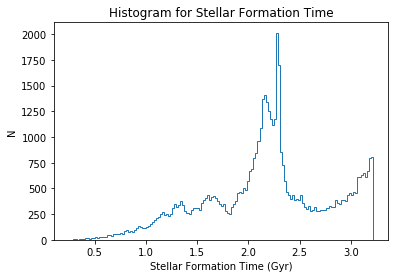

In [8]:
#convert timescale from formation scalefactor units to redshift
Z_starFormationTime = 1/starFormationTime -1
Gyr_starFormationTime = cosmo.age(Z_starFormationTime).value

plt.figure()
plt.title('Histogram for Stellar Formation Time')
#plt.xlim(0,max(starFormationTime)+0.01) 
#set 0 as lower xlim to exclude wind phase gas cell(s) --> negative values
plt.hist(Gyr_starFormationTime, bins=150, histtype="step")
plt.xlabel("Stellar Formation Time (Gyr)")
plt.ylabel("N")
#how many bins should be good?

In [9]:
#get stellar initial masses

id = 1
params = {'stars':'Coordinates,GFM_InitialMass'}

url = "http://www.tng-project.org/api/TNG100-1/snapshots/z=" + str(redshift) + "/subhalos/" + str(id)
sub = get(url) # get json response of subhalo properties
saved_filename = get(url + "/cutout.hdf5",params) # get and save HDF5 cutout file

with h5py.File(saved_filename) as f:
    dx = f['PartType4']['Coordinates'][:,0] - sub['pos_x']
    dy = f['PartType4']['Coordinates'][:,1] - sub['pos_y']
    dz = f['PartType4']['Coordinates'][:,2] - sub['pos_z']
    #starFormationTime = f['PartType4']['GFM_StellarFormationTime'][:]
    starInitialMass = f['PartType4']['GFM_InitialMass'][:]
    mode = 'r'


C:\Users\debos\anaconda3\lib\site-packages\ipykernel_launcher.py:10: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  # Remove the CWD from sys.path while we load stuff.


In [10]:
#testing initial mass data before plotting

print(starInitialMass[:5])
print(len(starInitialMass))
print(max(starInitialMass))

[9.63642306e-05 8.85811969e-05 1.04185856e-04 4.98385562e-05
 7.51211919e-05]
56139
0.00018878699


C:\Users\debos\anaconda3\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\debos\anaconda3\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


Text(0, 0.5, 'N')

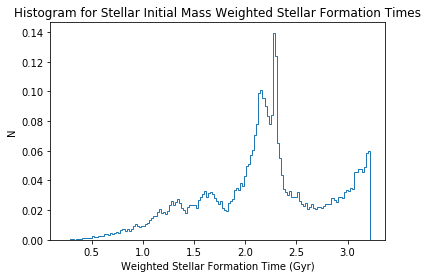

In [11]:
#convert GFM_InitialMass data from $M_\odot/h$ to $M_\odot$ units

M_Odot_starInitialMass = starInitialMass * h

#weighing ??? what is the procedure ?
#divide/multiply M_Odot_starInitialMass & Gyr_starFormationTime

#make histogram of formation time weighted by the initial mass

plt.figure()
plt.title('Histogram for Stellar Initial Mass Weighted Stellar Formation Times')
#plt.xlim(0,max(starFormationTime)+0.01) 
#set 0 as lower xlim to exclude wind phase gas cell(s) --> negative values
plt.hist(Gyr_starFormationTime, bins=150, weights=M_Odot_starInitialMass, histtype="step")
plt.xlabel("Weighted Stellar Formation Time (Gyr)")
plt.ylabel("N")
#how many bins should be good?
